# DROWSINESS DETECTION MODEL

Here, I shall try to build and train a model from scratch which would be able to detect drowsiness. The model shall be trained on the **MRL Eye Dataset**. This dataset contains infrared images in low and high resolution, all captured in various lightning conditions and by different devices.  

The dataset can be downloaded from [here](http://mrl.cs.vsb.cz/eyedataset "MRL Eye Dataset").  

In the dataset, we annotated the following properties (the properties are indicated in the following order):
- subject ID --> in the dataset, we collected the data of 37 different persons (33 men and 4 women)
- image ID --> the dataset consists of **84,898 images**
- gender [0 - man, 1 - woman] --> the dataset contains the information about gender for each image (man, woman)
- glasses [0 - no, 1 - yes] --> the information if the eye image contains glasses is also provided for each image (with and without the glasses)
- eye state [0 - closed, 1 - open] --> this property contains the information about two eye states (open, close)
- reflections [0 - none, 1 - small, 2 - big] --> we annotated three reflection states based on the size of reflections (none, small, and big reflections)
- lighting conditions [0 - bad, 1 - good] --> each image has two states (bad, good) based on the amount of light during capturing the videos
- sensor ID [01 - RealSense, 02 - IDS, 03 - Aptina] --> at this moment, the dataset contains the images captured by three different sensors (Intel RealSense RS 300 sensor with 640 x 480 resolution, IDS Imaging sensor with 1280 x 1024 resolution, and Aptina sensor with 752 x 480 resolution)

A sample file name, thus, would be *subject ID-image ID-gender-glasses-eye state-reflections-lighting conditions-sensor ID*

Examples of image annotations of the proposed dataset:
![](images\eyedataset_sample.png "Sample Examples")

---

### Take Out 10% of the Data
First, I shall experiment on about a tenth of the dataset and find the most promising models. Finally, I shall train the short-listed models on the full dataset and compare their performance. May the best model win
 ;)

In [5]:
import os


ROOT_DIR = ""
MRLDATASET_PATH = os.path.join(ROOT_DIR, "mrlEyes_2018_01")
DATA_PATH = os.path.join(ROOT_DIR, "data") # 10% of data would be stored here
os.makedirs(DATA_PATH, exist_ok=True) # create data directory

```
import shutil
import random
from tqdm import tqdm


# List all subject folders
# sd for 'sub_directory'
subjectFolders = [sd for sd in os.listdir(MRLDATASET_PATH) if \
    os.path.isdir(os.path.join(MRLDATASET_PATH, sd))]

# Test
print("The first 5 folders in subjectFolders:", subjectFolders[:6], sep="\n")
print("")
print("The length of subjectFolders is:", len(subjectFolders))
print("")

for folder in tqdm(subjectFolders, desc="Processing and copying files"):
    # Create corresponding folder in destination directory
    os.makedirs(os.path.join(DATA_PATH, folder), exist_ok=True)
    
    # List all image files in the current subject folder
    # f for 'file'
    allFiles = [f for f in os.listdir(os.path.join(MRLDATASET_PATH, folder)) \
        if f.endswith('.png')]
    
    # Shuffle and select 10%
    random.shuffle(allFiles)
    subsetFiles = allFiles[:int(0.1 * len(allFiles))]
    
    # Copy the selected files to the destination directory
    for file in tqdm(subsetFiles, desc=f"Copying files for {folder}"):
        shutil.copy(os.path.join(MRLDATASET_PATH, folder, file), 
        os.path.join(DATA_PATH, folder, file))
    # end for
# end for
```

### Segregating Images into Open and Closed Eyes Directories

In [6]:
listAllFolders = [sd for sd in os.listdir(DATA_PATH) if \
                  os.path.isdir(os.path.join(DATA_PATH, sd))]

listAllFolders

['test', 'train', 'validation']

```
OPENED_EYE_DIR = os.path.join(DATA_PATH, "opened")
os.makedirs(OPENED_EYE_DIR, exist_ok=True)

CLOSED_EYE_DIR = os.path.join(DATA_PATH, "closed")
os.makedirs(CLOSED_EYE_DIR, exist_ok=True)
```

In [7]:
sampleImgName = "s0001_00008_0_0_1_0_0_01.png"
print("Eye State:", sampleImgName.split("_")[4])
for i, info in enumerate(sampleImgName.split("_")):
    if i == 4:
        print(i, info, "<-- Eye State")
    else:
        print(i, info)
    # end if-else
# end for

Eye State: 1
0 s0001
1 00008
2 0
3 0
4 1 <-- Eye State
5 0
6 0
7 01.png


```
for folder in tqdm(listAllFolders, desc="Moving images to their \
respective label folder"):
    folderPath = os.path.join(DATA_PATH, folder)

    listAllFiles = [f for f in os.listdir(folderPath) if f.endswith(".png")]

    for file in tqdm(listAllFiles, desc=f"Moving images in folder {folder}"):
        # Check the eye status based on the naming convention of the file
        eyeState = file.split("_")[4]
        
        # 0 ==> "closed", 1 ==> "opened"
        if eyeState == '0':
            shutil.move(os.path.join(folderPath, file), \
                        os.path.join(CLOSED_EYE_DIR, file))
        elif eyeState == '1':
            shutil.move(os.path.join(folderPath, file), \
                        os.path.join(OPENED_EYE_DIR, file))
        # end if-elif
    # end for

    # After moving all images delete the empty folder
    os.rmdir(folderPath)
    print(f"Deleted folder {folder}!")
# end for
```

```
listAllClosedFiles = [f for f in os.listdir(CLOSED_EYE_DIR) if \
                      f.endswith(".png")]
print("# of closed images:", len(listAllClosedFiles))

listAllOpenedFiles = [f for f in os.listdir(OPENED_EYE_DIR) if \
                      f.endswith(".png")]
print("# of opened images:", len(listAllOpenedFiles))

print("Ratio of closed to opened:", len(listAllClosedFiles) / \
      len(listAllOpenedFiles))
```

### Split the Dataset into Train, Validation, and Test Sets

In [8]:
# Create the directories
TRAIN_DIR = os.path.join(DATA_PATH, 'train')
os.makedirs(TRAIN_DIR, exist_ok=True)

VALID_DIR = os.path.join(DATA_PATH, 'validation')
os.makedirs(VALID_DIR, exist_ok=True)

TEST_DIR = os.path.join(DATA_PATH, 'test')
os.makedirs(TEST_DIR, exist_ok=True)

In [9]:
# Create in each of the above created directories two more directories:
# 'opened' and 'closed'
for directory in (TRAIN_DIR, VALID_DIR, TEST_DIR):
    openedEyeDirHold = os.path.join(directory, 'opened')
    os.makedirs(openedEyeDirHold, exist_ok=True)

    closedEyeDirHold = os.path.join(directory, 'closed')
    os.makedirs(closedEyeDirHold, exist_ok=True)
# end for

In [10]:
# Split the data randomly by shuffling
import shutil
import random


def splitAndMoveFiles(src: str, trainDest: str, valDest: str, testDest: str,
                      splitRatio: tuple=(0.8, 0.1, 0.1)) -> None:
    """
    Function to split the images in src into trainDest, valDest, testDest by
    splitRatio
    """
    listFiles = [f for f in os.listdir(src) if f.endswith('.png')]
    random.shuffle(listFiles)

    trainPercent = int(splitRatio[0] * len(listFiles))
    valPercent = int(splitRatio[1] * len(listFiles))
    
    trainFiles = listFiles[: trainPercent]
    valFiles = listFiles[trainPercent: (trainPercent + valPercent)]
    testFiles = listFiles[(trainPercent + valPercent): ]

    for files in (trainFiles, valFiles, testFiles):
        destPath = {
            tuple(trainFiles): trainDest,
            tuple(valFiles): valDest,
            tuple(testFiles): testDest,
        }

        for file in files:
            shutil.move(
                os.path.join(src, file),
                os.path.join(destPath[tuple(files)], file)
            )
        # end for
    # end for
    
    return
# end function splitAndMoveFiles()

```
# Function calls
trainDest = os.path.join(TRAIN_DIR, 'opened')
valDest = os.path.join(VALID_DIR, 'opened')
testDest = os.path.join(TEST_DIR, 'opened')

splitAndMoveFiles(OPENED_EYE_DIR, trainDest, valDest, testDest)

trainDest = os.path.join(TRAIN_DIR, 'closed')
valDest = os.path.join(VALID_DIR, 'closed')
testDest = os.path.join(TEST_DIR, 'closed')

splitAndMoveFiles(CLOSED_EYE_DIR, trainDest, valDest, testDest)


# Delete the empty directories
os.rmdir(OPENED_EYE_DIR)
os.rmdir(CLOSED_EYE_DIR)
```

In [11]:
# Check the size of the directories
for directory in (TRAIN_DIR, VALID_DIR, TEST_DIR):
    print(f"In directory -> {directory}")
    subDirs = [sd for sd in os.listdir(directory) \
               if os.path.isdir(os.path.join(directory, sd))]
    
    for subDir in subDirs:
        print(f"    In sub directory -> {subDir}")
        listFiles = [f for f in os.listdir(os.path.join(directory, subDir))
                     if f.endswith('.png')]
        print(f"        # of files: {len(listFiles)}")
    # end for
# end for

In directory -> data\train
    In sub directory -> closed
        # of files: 3349
    In sub directory -> opened
        # of files: 3428
In directory -> data\validation
    In sub directory -> closed
        # of files: 418
    In sub directory -> opened
        # of files: 428
In directory -> data\test
    In sub directory -> closed
        # of files: 420
    In sub directory -> opened
        # of files: 429


### Exploratory Data Analysis (EDA)

In [12]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


def visualiseSamples(dirPath: str, title: str="Visualise Samples",
                     numOfSamples: int=5) -> None:
    """Function to visualise a sample of the image dataset"""

    files = [f for f in random.sample(os.listdir(dirPath), numOfSamples)
             if f.endswith('.png')]
    
    plt.figure(figsize=(15, 5))

    for i, file in enumerate(files):

        # Read the image
        imgPath = os.path.join(dirPath, file)
        img = cv2.imread(imgPath)
        print(f"Dimensions of image sample #{i + 1}: {img.shape}")
        
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        # nrows=1, ncols=numOfSamples, index=i+1
        plt.subplot(1, numOfSamples, i+1)
        plt.imshow(imgRGB)
    # end for

    plt.suptitle(title)
    plt.show()
    
    return
# end function visualiseSamples()

Dimensions of closed images:
Dimensions of image sample #1: (73, 73, 3)
Dimensions of image sample #2: (117, 117, 3)
Dimensions of image sample #3: (78, 78, 3)
Dimensions of image sample #4: (88, 88, 3)
Dimensions of image sample #5: (88, 88, 3)


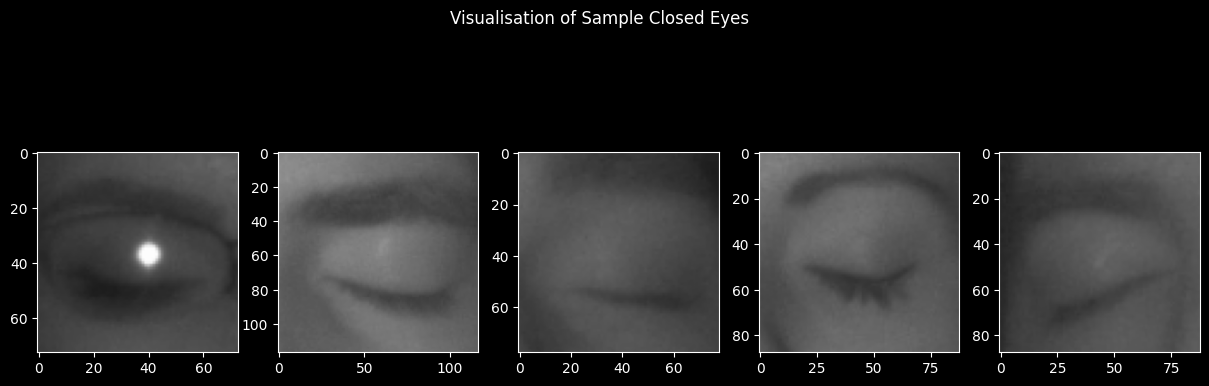

Dimensions of opened images:
Dimensions of image sample #1: (121, 121, 3)
Dimensions of image sample #2: (81, 81, 3)
Dimensions of image sample #3: (80, 80, 3)
Dimensions of image sample #4: (55, 55, 3)
Dimensions of image sample #5: (73, 73, 3)


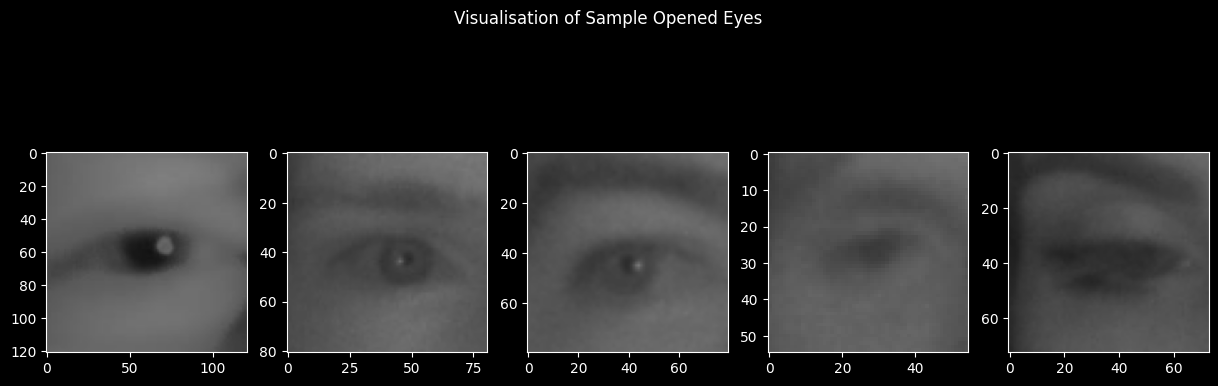

In [13]:
# Define image set paths
trainOpenedPath = os.path.join(TRAIN_DIR, 'opened')
trainClosedPath = os.path.join(TRAIN_DIR, 'closed')

# Visualise sample of closed eyes
print("Dimensions of closed images:")
visualiseSamples(trainClosedPath, title="Visualisation of Sample Closed Eyes")

# Visualise sample of opened eyes
print("Dimensions of opened images:")
visualiseSamples(trainOpenedPath, title="Visualisation of Sample Opened Eyes")

We see that the dimensions of the images in the datasets are varying. Thus, we need to resize all the datasets. However, we shall do that later. For now, we shall just continue our EDA.

Next, we shall see the Pixel Distribution of the images in the datasets.

```
def plotPixelIntensityDistribution(
        dirPath: str, title: str="Pixel Intensity Distribution"
) -> None:
    """Function to plot the pixel intensity distribution of the images"""
    pixelValues = []

    files = [f for f in os.listdir(dirPath) if f.endswith('.png')]
    for file in files:
        imgPath = os.path.join(dirPath, file)
        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        pixelValues.extend(img.ravel())
    # end for

    plt.hist(pixelValues, bins=256, range=(0, 256), density=True, alpha=0.7,
             label=title)
    
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    return
# end function plotPixelIntensityDistribution()
```

#### Incremental Histogram
Instead of accumulating all pixel values and then plotting a histogram, you can compute the histogram incrementally for each image and then aggregate the results. This avoids the need to store all pixel values in memory.

In [20]:
import numpy as np


def incrementalHistogram(dirPath: str) -> np.ndarray[np.float64]:
    """Create histograms for each image and then aggregate results"""
    hist = np.zeros(256, dtype=int)
    for file in os.listdir(dirPath):
        if file.endswith('.png'):
            imgPath = os.path.join(dirPath, file)
            img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
            hist += np.bincount(img.ravel(), minlength=256)
        # end if
    # end for

    return hist
# end function incrementalHistogram()

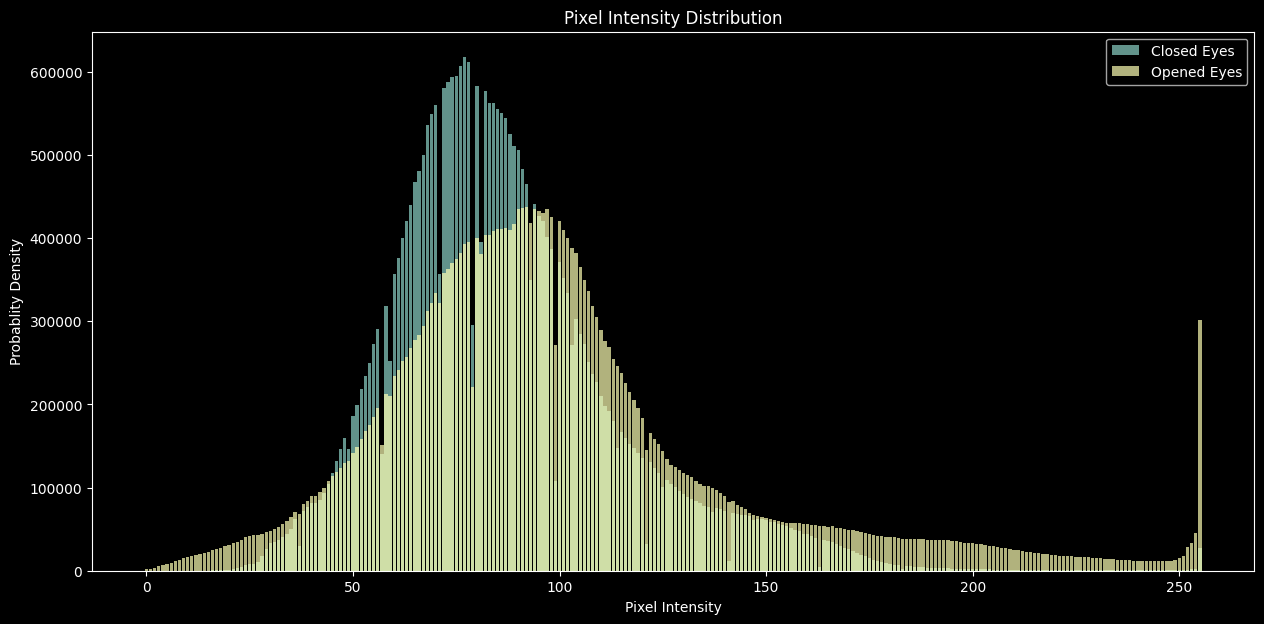

In [26]:
# Compute histograms incrementally
closedHist = incrementalHistogram(trainClosedPath)
openedHist = incrementalHistogram(trainOpenedPath)

plt.figure(figsize=(15, 7))
plt.bar(range(256), closedHist, alpha=0.7, label="Closed Eyes")
plt.bar(range(256), openedHist, alpha=0.7, label="Opened Eyes")
plt.title("Pixel Intensity Distribution")
plt.xlabel('Pixel Intensity')
plt.ylabel('Probablity Density')
plt.legend()

plt.show()

Observations:
- The probability distribution of the pixel intensities is almost the same for both the datasets.
- Both the distributions are left-skewed which means they are dominated by the darker pixels.
- The distribution goes well till the last pixel values which indicates that there are some brighter regions in the images, but they are less frequent than the darker regions.
- Spiked region towards the end pixel values indicates that there are some very bright pixels in the images.

### Data Pre-processing
- Resize the images to a fixed size
- Normalise the pixel values

#### Resizing Images

In [28]:
def resizeImages(dirPath: str, targetSize: tuple=(224, 224)) -> list:
    """Resize the images in the given directory with the target size"""

    resizedImages = []

    for file in os.listdir(dirPath):
        if file.endswith('.png'):
            imgPath = os.path.join(dirPath, file)
            img = cv2.imread(imgPath)
            
            img = cv2.resize(img, targetSize)

            # Store the resized images
            resizedImages.append(img)
        # end if
    # end for

    return resizedImages
# end function resizeImages()

In [29]:
# Resize both the closed and opened eyes dataset (train images, for now)
resizedOpenedImgs = resizeImages(trainOpenedPath)
resizedClosedImgs = resizeImages(trainClosedPath)

In [34]:
resizedOpenedImgs[0].shape

(224, 224, 3)

In [35]:
resizedClosedImgs[45].shape

(224, 224, 3)

In [38]:
def visualiseSamplesFromList(imagesList: list, title: str="Visualise Samples",
                     numOfSamples: int=5) -> None:
    """Function to visualise a sample of the image from a list of images"""

    sampleImagesList = random.sample(imagesList, numOfSamples)
    
    plt.figure(figsize=(15, 5))

    for i, img in enumerate(sampleImagesList):
        print(f"Dimensions of image sample #{i + 1}: {img.shape}")

        # Plot the image
        # nrows=1, ncols=numOfSamples, index=i+1
        plt.subplot(1, numOfSamples, i+1)
        plt.imshow(img)
    # end for

    plt.suptitle(title)
    plt.show()
    
    return
# end function visualiseSamplesFromList()

Dimensions of image sample #1: (224, 224, 3)
Dimensions of image sample #2: (224, 224, 3)
Dimensions of image sample #3: (224, 224, 3)
Dimensions of image sample #4: (224, 224, 3)
Dimensions of image sample #5: (224, 224, 3)


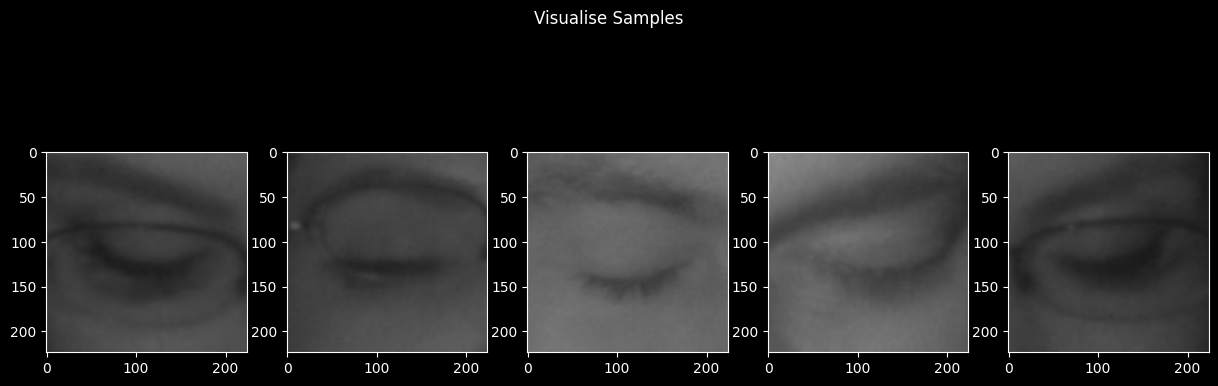

In [39]:
visualiseSamplesFromList(resizedClosedImgs)

Dimensions of image sample #1: (224, 224, 3)
Dimensions of image sample #2: (224, 224, 3)
Dimensions of image sample #3: (224, 224, 3)
Dimensions of image sample #4: (224, 224, 3)
Dimensions of image sample #5: (224, 224, 3)


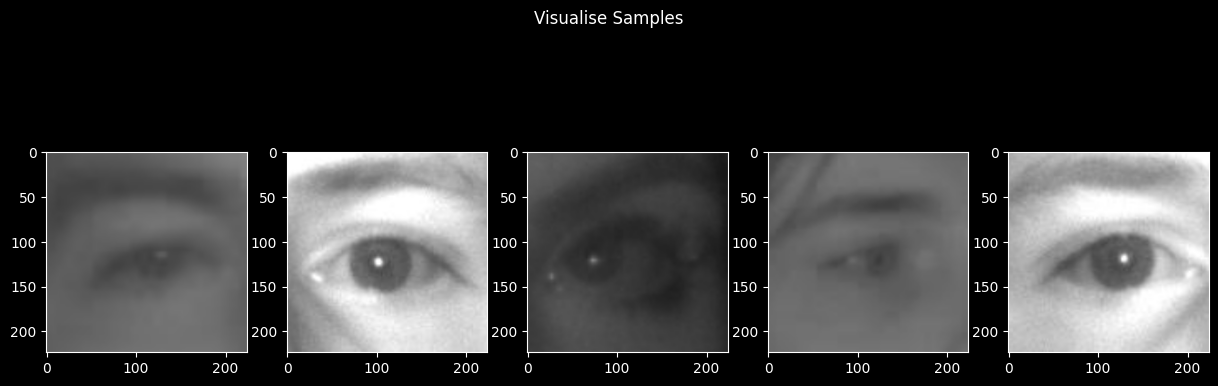

In [40]:
visualiseSamplesFromList(resizedOpenedImgs)

#### Normalising Images

In [41]:
def normaliseImages(imagesList: list) -> np.ndarray:
    """Normalise a list of images"""

    # Normalise pixel values to be between 0 to 1 => divide pixel values by 255
    # for an RGB image
    normalisedImages = [img / 255.0 for img in imagesList]

    return np.array(normalisedImages)
# end function normaliseImages()

In [42]:
normalisedClosedImgs = normaliseImages(resizedClosedImgs)
normalisedOpenedImgs = normaliseImages(resizedOpenedImgs)

In [48]:
normalisedOpenedImgs[87].shape

(224, 224, 3)

In [49]:
normalisedClosedImgs[21].shape

(224, 224, 3)

#### Converting the images to grayscale for reduced computation
For detecting eyes and check if they are opened or closed has little to do with the color of the eyes. Thus, we can convert the images to grayscale to reduce the computation.

In [52]:
def convert2Grayscale_and_reshape(imgList: list) -> np.ndarray:
    """
    Convert images from a list to grayscale and reshape each image to also
    contain an explicit channel dimension
    """
    grayscaleImgs = []
    for img in imgList:
        # Convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Reshape with extra channel dimension
        img = img.reshape(img.shape[0], img.shape[1], 1)

        grayscaleImgs.append(img)
    # end for

    return np.array(grayscaleImgs)
# end function convert2Grayscale_and_reshape()

In [54]:
grayOpenedImgs = convert2Grayscale_and_reshape(resizedOpenedImgs)
grayClosedImgs = convert2Grayscale_and_reshape(resizedClosedImgs)

In [55]:
grayClosedImgs[90].shape

(224, 224, 1)

In [56]:
grayOpenedImgs[890].shape

(224, 224, 1)

In [57]:
grayOpenedImgs[90]

array([[[ 34],
        [ 34],
        [ 34],
        ...,
        [122],
        [122],
        [122]],

       [[ 34],
        [ 34],
        [ 34],
        ...,
        [122],
        [122],
        [122]],

       [[ 33],
        [ 33],
        [ 34],
        ...,
        [124],
        [124],
        [124]],

       ...,

       [[ 34],
        [ 34],
        [ 36],
        ...,
        [ 88],
        [ 88],
        [ 88]],

       [[ 34],
        [ 34],
        [ 36],
        ...,
        [ 88],
        [ 88],
        [ 88]],

       [[ 34],
        [ 34],
        [ 36],
        ...,
        [ 88],
        [ 88],
        [ 88]]], dtype=uint8)

In [58]:
# Normalising the grayscale images
trainClosedImgs = normaliseImages(grayClosedImgs)
trainOpenedImgs = normaliseImages(grayOpenedImgs)

In [59]:
trainClosedImgs[992]

array([[[0.15686275],
        [0.15686275],
        [0.16078431],
        ...,
        [0.55686275],
        [0.55686275],
        [0.55686275]],

       [[0.15686275],
        [0.15686275],
        [0.16078431],
        ...,
        [0.55686275],
        [0.55686275],
        [0.55686275]],

       [[0.16078431],
        [0.16078431],
        [0.16470588],
        ...,
        [0.56078431],
        [0.56078431],
        [0.55686275]],

       ...,

       [[0.22352941],
        [0.22745098],
        [0.24313725],
        ...,
        [0.38039216],
        [0.38039216],
        [0.38039216]],

       [[0.23137255],
        [0.23137255],
        [0.24313725],
        ...,
        [0.38039216],
        [0.38039216],
        [0.38039216]],

       [[0.23137255],
        [0.23529412],
        [0.24705882],
        ...,
        [0.38039216],
        [0.38039216],
        [0.38039216]]])

In [60]:
trainOpenedImgs[2333]

array([[[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.81960784],
        [0.80392157],
        [0.8       ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.81568627],
        [0.80392157],
        [0.8       ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.81568627],
        [0.80392157],
        [0.79607843]],

       ...,

       [[0.39215686],
        [0.38039216],
        [0.35686275],
        ...,
        [0.63529412],
        [0.63921569],
        [0.63921569]],

       [[0.41960784],
        [0.40784314],
        [0.39215686],
        ...,
        [0.63529412],
        [0.63529412],
        [0.63529412]],

       [[0.43137255],
        [0.42352941],
        [0.40392157],
        ...,
        [0.63529412],
        [0.63529412],
        [0.63529412]]])

In [62]:
trainOpenedImgs.shape

(3428, 224, 224, 1)

In [64]:
trainClosedImgs.shape

(3349, 224, 224, 1)

### Training Model